# Export onnx for TensorRT8.0+ end2end detect !!!

In [1]:
# export onnx first
!python export.py --weights weights/yolov7-d6.pt --grid --end2end --simplify --topk-all 100 --iou-thres 0.65 --conf-thres 0.35

Namespace(batch_size=1, conf_thres=0.35, device='cpu', dynamic=False, end2end=True, grid=True, img_size=[640, 640], iou_thres=0.65, max_wh=None, simplify=True, topk_all=100, weights='weights/yolov7-d6.pt')
YOLOR 🚀 v0.1-51-g2596994 torch 1.12.0+cu116 CPU

Fusing layers... 
Model Summary: 539 layers, 133757052 parameters, 133757052 gradients
/home/ubuntu/miniconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Starting TorchScript export with torch 1.12.0+cu116...
/home/ubuntu/work/yolo/yolov7/models/yolo.py:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that 

In [2]:
# convert onnx to tensorrt engine
!/usr/src/tensorrt/bin/trtexec --onnx=weights/yolov7-d6.onnx --saveEngine=weights/yolov7-d6.engine

&&&& RUNNING TensorRT.trtexec [TensorRT v8401] # /usr/src/tensorrt/bin/trtexec --onnx=weights/yolov7-d6.onnx --saveEngine=weights/yolov7-d6.engine
[07/22/2022-16:21:28] [I] === Model Options ===
[07/22/2022-16:21:28] [I] Format: ONNX
[07/22/2022-16:21:28] [I] Model: weights/yolov7-d6.onnx
[07/22/2022-16:21:28] [I] Output:
[07/22/2022-16:21:28] [I] === Build Options ===
[07/22/2022-16:21:28] [I] Max batch: explicit batch
[07/22/2022-16:21:28] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[07/22/2022-16:21:28] [I] minTiming: 1
[07/22/2022-16:21:28] [I] avgTiming: 8
[07/22/2022-16:21:28] [I] Precision: FP32
[07/22/2022-16:21:28] [I] LayerPrecisions: 
[07/22/2022-16:21:28] [I] Calibration: 
[07/22/2022-16:21:28] [I] Refit: Disabled
[07/22/2022-16:21:28] [I] Sparsity: Disabled
[07/22/2022-16:21:28] [I] Safe mode: Disabled
[07/22/2022-16:21:28] [I] DirectIO mode: Disabled
[07/22/2022-16:21:28] [I] Restricted mode: Disabled
[07/22/2022-1

In [3]:
import cv2
import requests
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [4]:
w = 'weights/yolov7-d6.engine'
device = torch.device('cuda:0')

In [ ]:
# # Create TensorRT Engine
# onnx_file = 'yolov5s.onnx'
# engine_file = 'yolov5s.engine'
# verbose = False
# workspace = 8

# logger = trt.Logger(trt.Logger.INFO)
# if verbose:
#     logger.min_severity = trt.Logger.Severity.VERBOSE

# builder = trt.Builder(logger)
# config = builder.create_builder_config()
# config.max_workspace_size = workspace * 1 << 30

# flag = (1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
# network = builder.create_network(flag)
# parser = trt.OnnxParser(network, logger)
# parser.parse_from_file(onnx_file)

# with builder.build_serialized_network(network, config) as engine, open(engine_file,'wb') as t:
#     t.write(engine)

In [5]:
# Infer TensorRT Engine
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

[07/22/2022-16:24:57] [TRT] [I] [MemUsageChange] Init CUDA: CPU +328, GPU +0, now: CPU 402, GPU 300 (MiB)
[07/22/2022-16:24:57] [TRT] [I] Loaded engine size: 631 MiB
[07/22/2022-16:24:58] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +872, GPU +378, now: CPU 1953, GPU 1310 (MiB)
[07/22/2022-16:24:58] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +125, GPU +60, now: CPU 2078, GPU 1370 (MiB)
[07/22/2022-16:24:58] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.3.2
[07/22/2022-16:24:58] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +628, now: CPU 0, GPU 628 (MiB)
[07/22/2022-16:24:59] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2454, GPU 1822 (MiB)
[07/22/2022-16:24:59] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2454, GPU 1830 (MiB)
[07/22/2022-16:24:59] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.3.2
[07/22/2022-16:24:59] [TRT] [I] [MemUsage

In [6]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

In [7]:
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [8]:
url = 'https://oneflow-static.oss-cn-beijing.aliyuncs.com/tripleMu/image1.jpg'
file = requests.get(url)
img = cv2.imdecode(np.frombuffer(file.content, np.uint8), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

In [9]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape

torch.Size([1, 3, 640, 640])

In [10]:
# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1,3,640,640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

In [11]:
start = time.perf_counter()
binding_addrs['images'] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

Cost 0.023061261999828275 s


In [12]:
nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape

(torch.Size([1, 1]),
 torch.Size([1, 100, 4]),
 torch.Size([1, 100]),
 torch.Size([1, 100]))

In [13]:
nums

tensor([[4]], device='cuda:0', dtype=torch.int32)

In [14]:
boxes = boxes[0,:nums[0][0]]
scores = scores[0,:nums[0][0]]
classes = classes[0,:nums[0][0]]

In [15]:
for box,score,cl in zip(boxes,scores,classes):
    box = postprocess(box,ratio,dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

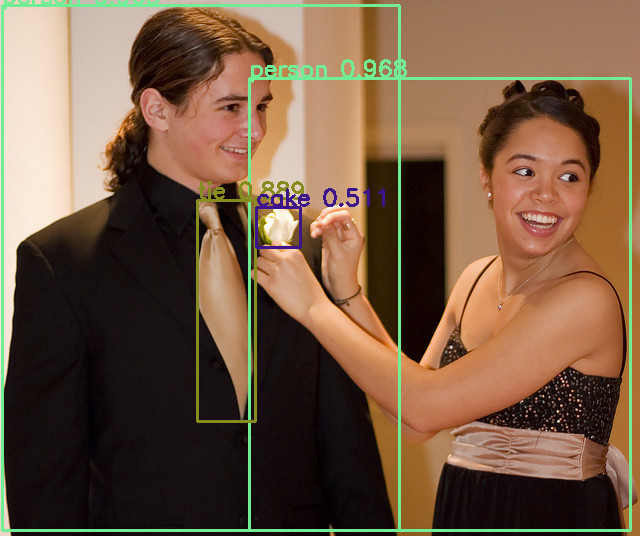

In [16]:
Image.fromarray(img)